# Hyperparameter optimization

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## GloVE

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

## Grand features

In [3]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [4]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [5]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

We assume results that are dictionaries. 

First, a function for aggregating results by particular labels, into a single dictionary. For example, when results are aggregated by category and feature, the result will be a dictionary whose keys are category/feature tuples, and the values are lists of result dictionaries. 

Second, a function that computes mean, median, and standard deviation, over a list of result dictionaries, for a given labels.

In [6]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval


# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

# Making a development set

In [7]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

In [8]:
num_randseeds = 3

# Testing

In [10]:
jitter_vals = [True, False]
offset_vals= [0.1, 0.2]

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]
randoms = [123]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(oval, jval, ocp_mean, mse_med)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)

0.1 True 0.5947360867285961 13.556062812473154
0.2 True 0.6208540494553738 14.240234086793757
0.1 False 0.6095014702783803 12.031678711442432
0.2 False 0.6076964995861299 13.459770517323733


In [14]:
results_byparam = [ ]

for theseresults in results.values():
    offset = theseresults[0]["offset"]
    jitter = theseresults[0]["j"]
    
    results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
    ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
    mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]
    
    results_byparam.append({ "offset": offset, "j":jitter, 
                            "ocp_mean": statistics.mean(ocps), "ocp_sd": statistics.stdev(ocps),
                            "msemed_mean" : statistics.mean(mses), "msemed_sd" : statistics.stdev(mses)})


In [15]:
df = pd.DataFrame(results_byparam)
df

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.1,True,0.594736,0.029014,14.361327,6.854013
1,0.2,True,0.620854,0.035204,15.243181,5.583644
2,0.1,False,0.609501,0.025609,13.541648,7.180967
3,0.2,False,0.607696,0.039671,14.137310,4.748247


In [ ]:
raise Exception("stop")

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests 10 times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [16]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(oval, jval, ocp_mean, mse_med)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)
    


0.1 True 0.495467400569577 183.25629574173246
0.2 True 0.5193852449795092 200.94083980995515
0.3 True 0.5129577401596531 185.0480753908472
0.4 True 0.5155792915916415 193.6262256138201
0.5 True 0.527050745074016 168.3310753254783
0.6 True 0.5224848800870872 216.66082170536248
0.7 True 0.5038935808196092 213.27496473343507
0.7999999999999999 True 0.49494943846082956 233.99858218868778
0.8999999999999999 True 0.5116722240381084 211.6411256355259
0.9999999999999999 True 0.5306578922757529 221.9680624269131
1.0999999999999999 True 0.5162532565485372 228.67706429067988
1.2 True 0.5129319426531069 214.26597969577347
1.3 True 0.5267213315986362 237.91628413863583
1.4 True 0.5063165476738783 244.82195443650028
1.5 True 0.5170662224933138 263.5843234527663
1.5999999999999999 True 0.512131066478982 222.60779763478433
1.7 True 0.5216201567110665 221.15555859538142
1.8 True 0.5294630009138196 227.80222819377852
1.9 True 0.5235935278934982 195.93516004387743
2.0 True 0.5339916129613231 229.85632119

In [17]:
results_byparam = [ ]

for theseresults in results.values():
    offset = theseresults[0]["offset"]
    jitter = theseresults[0]["j"]
    
    results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
    ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
    mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]
    
    results_byparam.append({ "offset": offset, "j":jitter, 
                            "ocp_mean": statistics.mean(ocps), "ocp_sd": statistics.stdev(ocps),
                            "msemed_mean" : statistics.mean(mses), "msemed_sd" : statistics.stdev(mses)})


In [18]:
df = pd.DataFrame(results_byparam)
df.head()


,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.1,True,0.513446,0.023978,242.300444,151.940079
1,0.2,True,0.507181,0.019516,220.669165,70.401835
2,0.3,True,0.529115,0.021144,274.601053,152.517325
3,0.4,True,0.514172,0.026899,257.904918,176.860336
4,0.5,True,0.522342,0.017525,266.776676,172.391971


We plot mean OC_P values, with standard deviation. The differences in result are minimal compared to the error bars: It basically doesn't matter which value we pick. 

<AxesSubplot: xlabel='offset'>

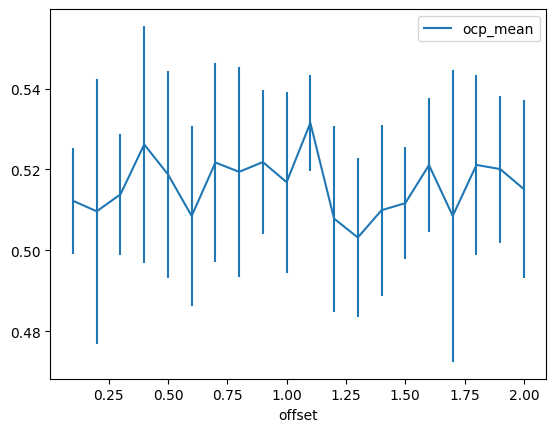

In [20]:
%matplotlib inline
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_sd")

<AxesSubplot: xlabel='offset'>

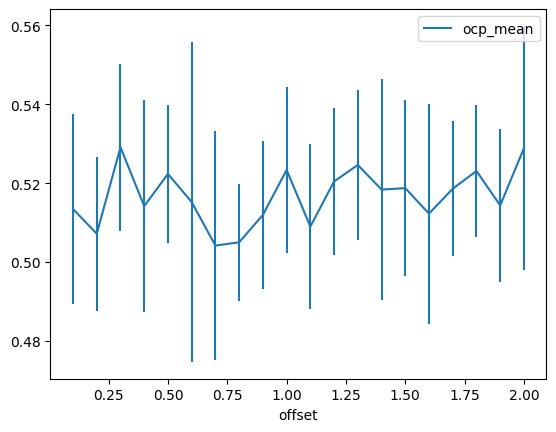

In [21]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_sd")

We plot mean values of median MSE, with standard deviation. Here the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

<AxesSubplot: xlabel='offset'>

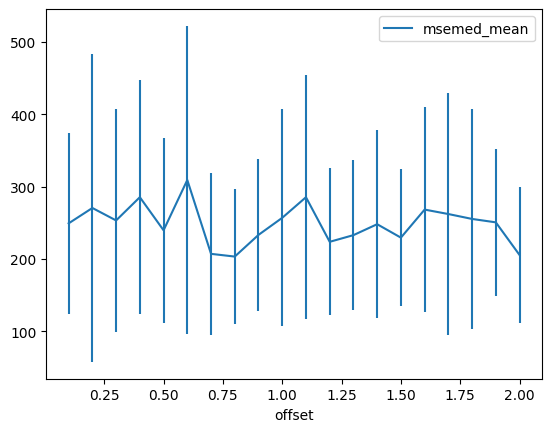

In [22]:
df[df.j == False].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

<AxesSubplot: xlabel='offset'>

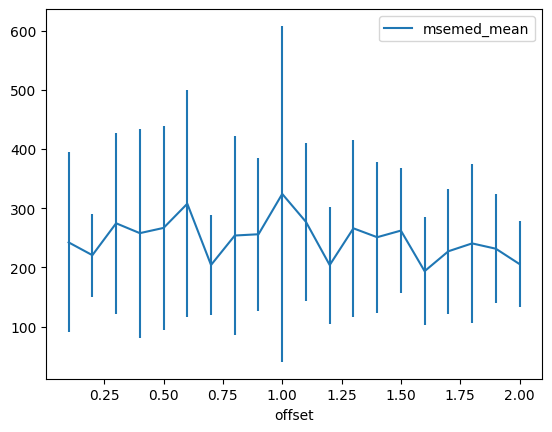

In [23]:
df[df.j == True].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

### Parameters for seeds as words

Because we need to pick some value, we pick the one with third best OC_P, which is very close to the best OC_P but with much lower MSE. We use an **offset of 2.0, with jitter.** 

In [24]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
30,1.1,False,0.531518,0.011786,285.381360,168.491271
2,0.3,True,0.529115,0.021144,274.601053,152.517325
19,2.0,True,0.528864,0.031003,205.595868,72.422202
23,0.4,False,0.526195,0.029300,285.393872,161.854764
12,1.3,True,0.524612,0.018941,266.058579,149.822384
9,1.0,True,0.523352,0.021105,324.212190,283.953460
17,1.8,True,0.523079,0.016756,240.581825,133.956249
4,0.5,True,0.522342,0.017525,266.776676,172.391971
28,0.9,False,0.521831,0.017832,233.296899,104.627330
26,0.7,False,0.521724,0.024691,207.089613,112.086395


In [25]:
df.sort_values(by = "msemed_mean", ascending = True).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
15,1.6,True,0.512273,0.027922,193.641419,91.798017
27,0.8,False,0.519419,0.026027,203.327884,93.497082
11,1.2,True,0.520427,0.018683,204.009896,98.835602
6,0.7,True,0.504162,0.028958,204.130968,85.015880
39,2.0,False,0.515129,0.022052,205.481632,94.165172
19,2.0,True,0.528864,0.031003,205.595868,72.422202
26,0.7,False,0.521724,0.024691,207.089613,112.086395
1,0.2,True,0.507181,0.019516,220.669165,70.401835
31,1.2,False,0.507853,0.022978,223.729981,101.647093
16,1.7,True,0.518591,0.017071,227.277035,105.435544


## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [26]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = defaultdict(list)

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r)            



0.001 True 0.6967889645693668 6.699518560479867
0.028666666666666667 True 0.6993230334126693 3.6532342393493145
0.05633333333333333 True 0.6937578866959 4.09543923158799
0.08399999999999999 True 0.6869638795755352 5.257219490325207
0.11166666666666666 True 0.6655857976013659 4.674470544759496
0.13933333333333334 True 0.6711614338222956 6.607564557279873
0.16699999999999998 True 0.6509548213489533 6.9557361815154986
0.19466666666666665 True 0.6589503765009395 7.174194042281053
0.22233333333333333 True 0.6508167954078274 6.649698361137226
0.25 True 0.6493485665022746 6.051817849151556
0.001 False 0.6799844007915852 6.140289364656391
0.028666666666666667 False 0.6832304033530413 5.070304661168019
0.05633333333333333 False 0.6572443333905853 6.207010194502168
0.08399999999999999 False 0.6778841049658062 5.392071418005525
0.11166666666666666 False 0.6451395081756822 6.700090456720092
0.13933333333333334 False 0.6482491261433492 7.756210150925082
0.16699999999999998 False 0.6475727754367518 

In [28]:
results_byparam = [ ]

for theseresults in results.values():
    alpha = theseresults[0]["alpha"]
    avg = theseresults[0]["avg"]
    
    results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
    ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
    mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]
    
    results_byparam.append({ "alpha": alpha, "avg":avg, 
                            "ocp_mean": statistics.mean(ocps), "ocp_sd": statistics.stdev(ocps),
                            "msemed_mean" : statistics.mean(mses), "msemed_sd" : statistics.stdev(mses)})


In [29]:
df = pd.DataFrame(results_byparam)
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.696789,0.078737,17.496412,27.729810
1,0.028667,True,0.699323,0.083539,6.384324,6.153508
2,0.056333,True,0.693758,0.076228,7.367539,5.883733
3,0.084000,True,0.686964,0.082408,7.194648,5.115591
4,0.111667,True,0.665586,0.090661,7.214904,4.985395


<AxesSubplot: xlabel='alpha'>

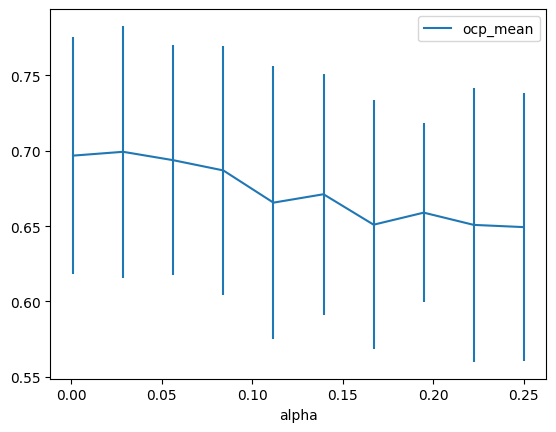

In [30]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

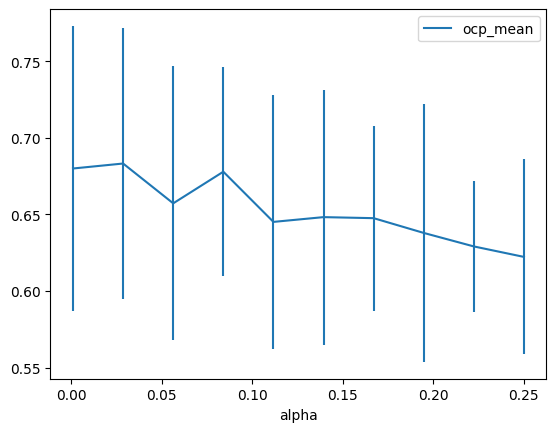

In [31]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

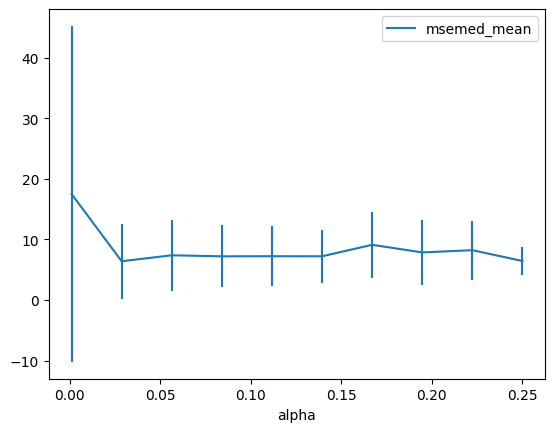

In [33]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

In [ ]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha, though again there is a large error bar. We explore the low range of alpha in more detail, both with and without averaging. 

In [35]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.15, num=10)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r) 

0.001 True 0.6711001375302544 9.736039087240785
0.017555555555555557 True 0.704318060933692 3.1441821852226646
0.03411111111111111 True 0.6795944696918144 5.369752166428208
0.050666666666666665 True 0.6710695805107006 6.46424055551479
0.06722222222222222 True 0.6581959734848303 9.675118673061668
0.08377777777777778 True 0.6604228907662684 15.322526388684501
0.10033333333333333 True 0.651785114499496 13.594071707216507
0.11688888888888889 True 0.657719005998995 12.81477705020821
0.13344444444444445 True 0.645290472637148 16.953745788399633
0.15 True 0.6329288976600634 19.58091057739425
0.001 False 0.6649134175186435 6.524496135833461
0.017555555555555557 False 0.6702356405494981 8.195336516973896
0.03411111111111111 False 0.6496100287172801 12.058210441625434
0.050666666666666665 False 0.6656757893070658 16.979821387385527
0.06722222222222222 False 0.6481860891221627 16.021505769129448
0.08377777777777778 False 0.6367720423490865 18.433122697943357
0.10033333333333333 False 0.6274685893

In [36]:
results_byparam = [ ]

for theseresults in results.values():
    alpha = theseresults[0]["alpha"]
    avg = theseresults[0]["avg"]
    
    results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
    ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
    mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]
    
    results_byparam.append({ "alpha": alpha, "avg":avg, 
                            "ocp_mean": statistics.mean(ocps), "ocp_sd": statistics.stdev(ocps),
                            "msemed_mean" : statistics.mean(mses), "msemed_sd" : statistics.stdev(mses)})


In [37]:
df = pd.DataFrame(results_byparam)
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.672685,0.093665,18.749198,25.390920
1,0.017556,True,0.686918,0.091411,12.046159,13.985848
2,0.034111,True,0.657412,0.104513,20.593204,25.502695
3,0.050667,True,0.654381,0.097530,49.694215,64.049977
4,0.067222,True,0.638178,0.105794,31.304003,33.519131


We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

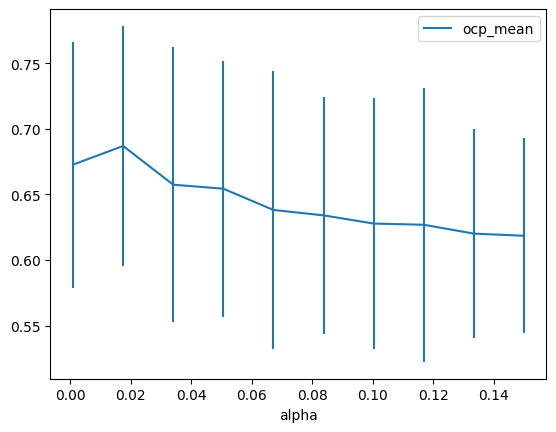

In [38]:
%matplotlib inline

df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

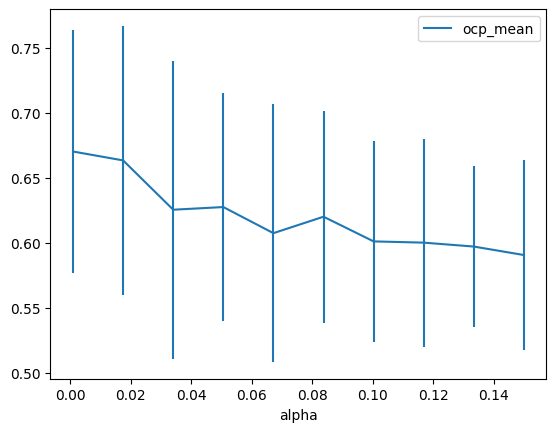

In [39]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

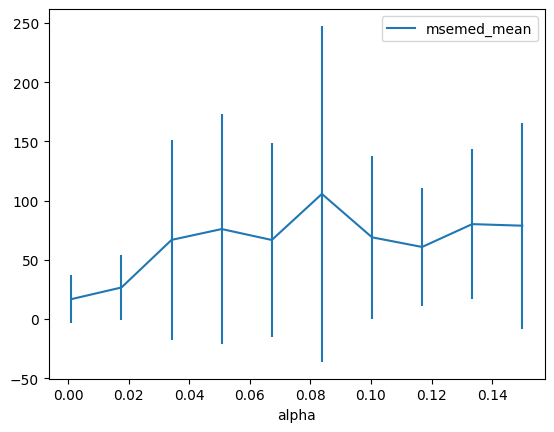

In [40]:
df[df.avg == False].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

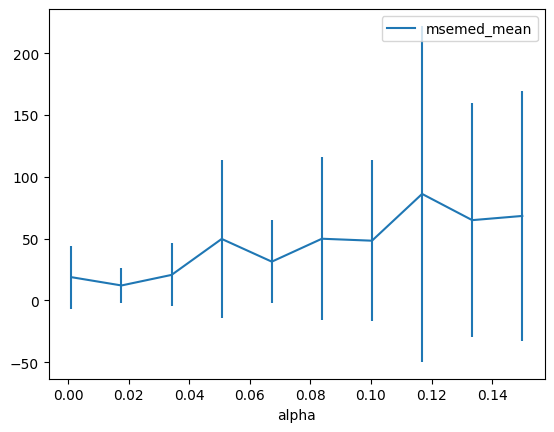

In [41]:
df[df.avg == True].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

We again see large error bars, meaning that there is wide difference across sub-datasets. Still, low values of alpha seem best both in terms of OC_P and MSE. 

We again look at the numbers.

In [42]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
1,0.017556,True,0.686918,0.091411,12.046159,13.985848
0,0.001000,True,0.672685,0.093665,18.749198,25.390920
2,0.034111,True,0.657412,0.104513,20.593204,25.502695


In [43]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.670315,0.093840,16.772100,20.232532
11,0.017556,False,0.663467,0.103554,26.624298,27.522628
13,0.050667,False,0.627557,0.087476,75.982278,96.940180


In [44]:
df[df.avg == False].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.670315,0.093840,16.772100,20.232532
11,0.017556,False,0.663467,0.103554,26.624298,27.522628
17,0.116889,False,0.600161,0.080168,60.841427,49.873221


In [45]:
df[df.avg == True].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
1,0.017556,True,0.686918,0.091411,12.046159,13.985848
0,0.001000,True,0.672685,0.093665,18.749198,25.390920
2,0.034111,True,0.657412,0.104513,20.593204,25.502695


In terms of both OC_P and MSE, the best value is at **alpha = 0.02, with averaging over seeds.** 

# Combined model: seeds as words and dimensions

We fix jitter to be true, and averaging to be true, in order not to have too many conditions. We also fix offset to being 1.3, as before, as offset never makes much of a difference. We test different alpha values, with 3 random conditions. 

In [46]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.15, num=10)
jitter_vals = [True]
offset_vals= [ 2.0 ]


results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    
                    ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
                    _, mse_med, _ = eval_summary_by(theseresults, "mse")
                    print(alphaval, avgval, oval, jval, ocp_mean, mse_med)
            
            
                    for r in theseresults:
                        r.update({"alpha":alphaval, "avg": avgval, "offset": oval, "j": jval})
                        results[ (str(alphaval), str(avgval))].append(r) 




0.001 True 2.0 True 0.6804861647097008 2.079185889570372
0.017555555555555557 True 2.0 True 0.7436743751741518 1.2845067083332455
0.03411111111111111 True 2.0 True 0.8209818164852016 0.6840790074010661
0.050666666666666665 True 2.0 True 0.8385419644686622 0.4971661123038162
0.06722222222222222 True 2.0 True 0.8181132299300151 0.5463333550713758
0.08377777777777778 True 2.0 True 0.8182735570305569 0.5624443192215373
0.10033333333333333 True 2.0 True 0.8105352242497126 0.7304775572135936
0.11688888888888889 True 2.0 True 0.8067826489462511 0.7046788415484664
0.13344444444444445 True 2.0 True 0.8082058087702599 0.6046088347926357
0.15 True 2.0 True 0.797403140485472 0.7796589724587663
0.001 True 2.0 True 0.7005695856025236 1.8834735829695815
0.017555555555555557 True 2.0 True 0.7642955334752298 0.9048155781502693
0.03411111111111111 True 2.0 True 0.8203769047461094 0.5856329858679508
0.050666666666666665 True 2.0 True 0.8268471475588274 0.5450600894743007
0.06722222222222222 True 2.0 True

In [49]:
results_byparam = [ ]

for theseresults in results.values():
    alpha = theseresults[0]["alpha"]
    avg = theseresults[0]["avg"]
    offset = theseresults[0]["offset"]
    jitter = theseresults[0]["j"]
    
    results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
    ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
    mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]
    
    results_byparam.append({ "alpha": alpha, "avg":avg, 
                            "offset" : offset, "j": jitter,
                            "ocp_mean": statistics.mean(ocps), "ocp_sd": statistics.stdev(ocps),
                            "msemed_mean" : statistics.mean(mses), "msemed_sd" : statistics.stdev(mses)})


In [50]:
df = pd.DataFrame(results_byparam)
df.head()


,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,2.0,True,0.695770,0.058477,2.228829,0.728174
1,0.017556,True,2.0,True,0.754649,0.039896,1.013726,0.210966
2,0.034111,True,2.0,True,0.818701,0.033052,0.663813,0.258095
3,0.050667,True,2.0,True,0.829848,0.036971,0.551913,0.288093
4,0.067222,True,2.0,True,0.822389,0.041574,0.663386,0.322240


## Plotting the results



<AxesSubplot: xlabel='alpha'>

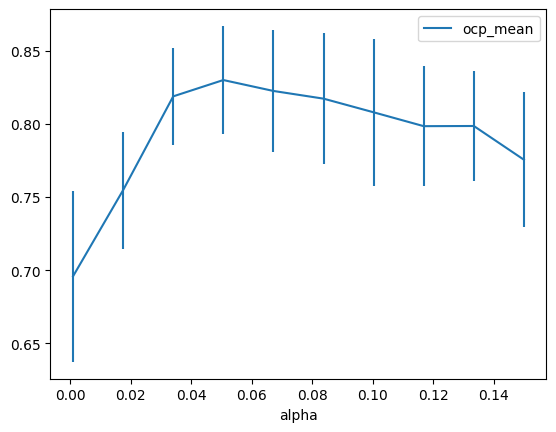

In [51]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

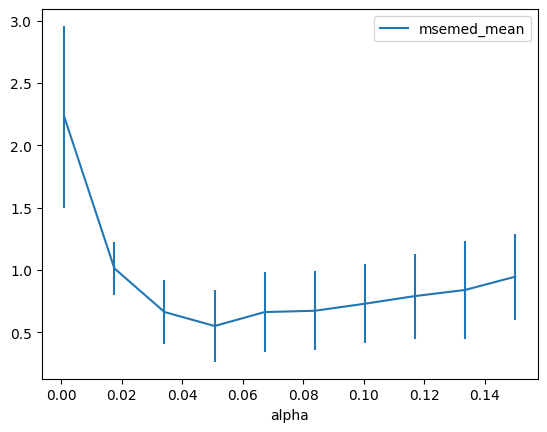

In [52]:
df.plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [53]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
3,0.050667,True,2.0,True,0.829848,0.036971,0.551913,0.288093
4,0.067222,True,2.0,True,0.822389,0.041574,0.663386,0.322240
2,0.034111,True,2.0,True,0.818701,0.033052,0.663813,0.258095
5,0.083778,True,2.0,True,0.817139,0.044639,0.673957,0.318206
6,0.100333,True,2.0,True,0.807811,0.050112,0.730347,0.318032


Both OC_P and MSE have a clear best value at **alpha = 0.05**. We use **averaging, jitter, and an offset of 2.0**,